In [ ]:
"""
World Cup 2022 Play Analysis using VAE
======================================
This notebook finds basis functions and similar plays in FIFA World Cup 2022 match data.

To use in Google Colab:
1. Upload this file to Colab or copy the code
2. Run each section in order
3. Make sure to mount your Google Drive first

Author: Generated for university project
"""

'\nWorld Cup 2022 Play Analysis using VAE\n======================================\nThis notebook finds basis functions and similar plays in FIFA World Cup 2022 match data.\n\nTo use in Google Colab:\n1. Upload this file to Colab or copy the code\n2. Run each section in order\n3. Make sure to mount your Google Drive first\n\nAuthor: Generated for university project\n'

In [ ]:
# =============================================================================
# SECTION 1: SETUP AND IMPORTS
# =============================================================================
print("=" * 60)
print("SECTION 1: SETUP AND IMPORTS")
print("=" * 60)

# Install required packages (uncomment if running in Colab)
!pip install torch numpy pandas scikit-learn matplotlib seaborn tqdm umap-learn

import os
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Progress bar
from tqdm import tqdm

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

SECTION 1: SETUP AND IMPORTS
Using device: cuda
GPU: Tesla T4


In [ ]:
# =============================================================================
# SECTION 2: GOOGLE DRIVE MOUNTING AND DATA LOADING
# =============================================================================
print("\n" + "=" * 60)
print("SECTION 2: DATA LOADING")
print("=" * 60)

# --- GOOGLE COLAB VERSION ---
# Uncomment these lines if running in Google Colab:

from google.colab import drive
drive.mount('/content/drive')

# Set your paths - update these to match your Drive structure
MATCHES_PATH = '/content/drive/MyDrive/Event Data'  # Folder with 64 JSON files
PLAYERS_PATH = '/content/drive/MyDrive/Player Data/players.csv'


"""
# --- LOCAL VERSION ---
# For testing locally, use these paths:
MATCHES_PATH = r'd:\world cup'  # Update this to your local path
PLAYERS_PATH = r'd:\world cup\players.csv'
"""

def load_match(filepath: str) -> List[Dict]:
    """Load a single match JSON file."""
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def load_all_matches(folder_path: str, max_matches: int = None) -> Dict[int, List[Dict]]:
    """
    Load all match JSON files from folder.

    Args:
        folder_path: Path to folder containing match JSON files
        max_matches: Maximum number of matches to load (None = all)

    Returns:
        Dictionary mapping game_id to list of events
    """
    matches = {}
    json_files = [f for f in os.listdir(folder_path)
                  if f.endswith('.json') and not f.endswith('(1).json')
                  and not f.endswith('(2).json')]

    # Filter to only match files (numeric names like 3812.json)
    match_files = []
    for f in json_files:
        name = f.replace('.json', '')
        if name.isdigit():
            match_files.append(f)

    match_files = sorted(match_files)
    if max_matches:
        match_files = match_files[:max_matches]

    print(f"Found {len(match_files)} match files")

    for filename in tqdm(match_files, desc="Loading matches"):
        filepath = os.path.join(folder_path, filename)
        game_id = int(filename.replace('.json', ''))
        try:
            matches[game_id] = load_match(filepath)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return matches

def load_players(filepath: str) -> pd.DataFrame:
    """Load player information."""
    return pd.read_csv(filepath)

# Load the data
print("Loading match data...")
matches = load_all_matches(MATCHES_PATH, max_matches=None)  # Set to 4 for quick testing
print(f"Loaded {len(matches)} matches")

# Count total events
total_events = sum(len(events) for events in matches.values())
print(f"Total events across all matches: {total_events:,}")

# Load player info
print("Loading player data...")
players_df = load_players(PLAYERS_PATH)
print(f"Loaded {len(players_df)} players")


SECTION 2: DATA LOADING
Mounted at /content/drive
Loading match data...
Found 64 match files


Loading matches: 100%|██████████| 64/64 [01:59<00:00,  1.87s/it]


Loaded 64 matches
Total events across all matches: 144,541
Loading player data...
Loaded 2321 players


In [ ]:
# =============================================================================
# SECTION 3: PLAY SEGMENTATION
# =============================================================================
print("\n" + "=" * 60)
print("SECTION 3: PLAY SEGMENTATION")
print("=" * 60)

@dataclass
class Play:
    """Represents a possession sequence (play)."""
    game_id: int
    play_id: int
    team_id: int
    team_name: str
    events: List[Dict]
    start_time: float
    end_time: float
    period: int
    set_piece_type: str

    @property
    def duration(self) -> float:
        return self.end_time - self.start_time

    @property
    def num_events(self) -> int:
        return len(self.events)

def segment_plays(match_events: List[Dict], game_id: int) -> List[Play]:
    """
    Segment a match into individual plays (possession sequences).

    A new play starts when:
    1. Team changes (possession lost)
    2. Set piece occurs
    3. Ball goes out of play
    4. Period changes
    """
    plays = []
    current_play_events = []
    current_team_id = None
    play_counter = 0

    for event in match_events:
        game_events = event.get('gameEvents', {})
        team_id = game_events.get('teamId')
        event_type = game_events.get('gameEventType', '')
        set_piece = game_events.get('setpieceType', 'O')
        period = game_events.get('period', 1)

        # Skip non-possession events
        if event_type in ['END', 'SUB', 'OFF', 'ON']:
            continue

        # Check if new play should start
        start_new_play = False

        if current_team_id is None:
            start_new_play = True
        elif team_id != current_team_id:
            start_new_play = True
        elif set_piece != 'O' and len(current_play_events) > 0:
            # Set piece starts new play
            start_new_play = True
        elif event_type == 'OUT':
            # Ball out starts new play
            start_new_play = True

        # Save current play if we're starting new one
        if start_new_play and current_play_events:
            first_event = current_play_events[0]
            last_event = current_play_events[-1]
            first_ge = first_event.get('gameEvents', {})

            play = Play(
                game_id=game_id,
                play_id=play_counter,
                team_id=current_team_id or 0,
                team_name=first_ge.get('teamName', 'Unknown'),
                events=current_play_events.copy(),
                start_time=first_event.get('startTime', 0),
                end_time=last_event.get('endTime', 0),
                period=first_ge.get('period', 1),
                set_piece_type=first_ge.get('setpieceType', 'O')
            )
            plays.append(play)
            play_counter += 1
            current_play_events = []

        # Add event to current play
        current_play_events.append(event)
        current_team_id = team_id

    # Don't forget last play
    if current_play_events:
        first_event = current_play_events[0]
        last_event = current_play_events[-1]
        first_ge = first_event.get('gameEvents', {})

        play = Play(
            game_id=game_id,
            play_id=play_counter,
            team_id=current_team_id or 0,
            team_name=first_ge.get('teamName', 'Unknown'),
            events=current_play_events.copy(),
            start_time=first_event.get('startTime', 0),
            end_time=last_event.get('endTime', 0),
            period=first_ge.get('period', 1),
            set_piece_type=first_ge.get('setpieceType', 'O')
        )
        plays.append(play)

    return plays

# Segment all matches into plays
print("Segmenting matches into plays...")
all_plays = []
for game_id, events in tqdm(matches.items(), desc="Segmenting"):
    plays = segment_plays(events, game_id)
    all_plays.extend(plays)

print(f"Total plays extracted: {len(all_plays):,}")
print(f"Average plays per match: {len(all_plays) / len(matches):.1f}")

# Filter out very short plays (< 2 events)
all_plays = [p for p in all_plays if p.num_events >= 2]
print(f"Plays with 2+ events: {len(all_plays):,}")

# Statistics
durations = [p.duration for p in all_plays]
num_events = [p.num_events for p in all_plays]
print(f"Play duration - Mean: {np.mean(durations):.2f}s, Median: {np.median(durations):.2f}s")
print(f"Events per play - Mean: {np.mean(num_events):.1f}, Median: {np.median(num_events):.0f}")


SECTION 3: PLAY SEGMENTATION
Segmenting matches into plays...


Segmenting: 100%|██████████| 64/64 [00:00<00:00, 72.38it/s]

Total plays extracted: 30,578
Average plays per match: 477.8
Plays with 2+ events: 16,475
Play duration - Mean: 11.79s, Median: 6.51s
Events per play - Mean: 7.9, Median: 5


In [ ]:
# =============================================================================
# SECTION 4: FEATURE ENGINEERING (UPDATED - 120 FEATURES)
# =============================================================================
print("\n" + "=" * 60)
print("SECTION 4: FEATURE ENGINEERING")
print("=" * 60)

from scipy.interpolate import interp1d

class FeatureExtractor:
    """Extract features from plays for VAE input."""

    # Event type mapping
    EVENT_TYPES = ['PA', 'CR', 'SH', 'CH', 'CL', 'BC', 'RE', 'TC', 'IT', 'OTHER']

    # Set piece types
    SET_PIECE_TYPES = ['O', 'C', 'F', 'G', 'K', 'T', 'D']

    # Pressure types
    PRESSURE_TYPES = ['N', 'A', 'P', 'L']

    # Pitch dimensions
    PITCH_LENGTH = 105.0
    PITCH_WIDTH = 68.0

    # Trajectory settings
    TRAJECTORY_POINTS = 20

    def __init__(self):
        self.feature_names = []
        self._build_feature_names()

    def _build_feature_names(self):
        """Build list of feature names for interpretability."""
        self.feature_names = []

        # === ORIGINAL 64 FEATURES ===
        # Spatial features
        self.feature_names.extend(['ball_x_start', 'ball_y_start', 'ball_x_end', 'ball_y_end'])
        self.feature_names.extend(['ball_dist_to_goal_start', 'ball_dist_to_goal_end'])
        self.feature_names.extend(['ball_zone_' + z for z in ['def_left', 'def_center', 'def_right',
                                                               'mid_left', 'mid_center', 'mid_right',
                                                               'att_left', 'att_center', 'att_right']])

        # Formation features
        self.feature_names.extend(['home_centroid_x', 'home_centroid_y',
                                   'away_centroid_x', 'away_centroid_y'])
        self.feature_names.extend(['home_spread_x', 'home_spread_y',
                                   'away_spread_x', 'away_spread_y'])
        self.feature_names.extend(['home_compactness', 'away_compactness'])
        self.feature_names.extend(['home_defensive_line', 'away_defensive_line'])

        # Event features
        self.feature_names.extend(['event_' + e for e in self.EVENT_TYPES])
        self.feature_names.extend(['setpiece_' + s for s in self.SET_PIECE_TYPES])
        self.feature_names.extend(['pressure_' + p for p in self.PRESSURE_TYPES])

        # Aggregate features
        self.feature_names.extend(['num_events', 'duration', 'passes_count', 'shots_count',
                                   'challenges_count', 'successful_passes_ratio'])

        # Movement features
        self.feature_names.extend(['avg_speed_home', 'avg_speed_away',
                                   'ball_carrier_speed_mean', 'ball_carrier_speed_max'])

        # Speed data quality and tempo features
        self.feature_names.extend(['has_speed_data', 'tempo'])

        # Foul feature
        self.feature_names.append('foul_count')

        # Progression features
        self.feature_names.extend(['x_progression', 'y_progression', 'distance_covered_ball'])

        # === NEW 55 FEATURES ===

        # Trajectory features (40) - interpolated ball path
        for i in range(self.TRAJECTORY_POINTS):
            self.feature_names.append(f'traj_x_{i+1}')
        for i in range(self.TRAJECTORY_POINTS):
            self.feature_names.append(f'traj_y_{i+1}')

        # Zone statistics (4)
        self.feature_names.extend(['zones_visited_count', 'pct_time_on_left',
                                   'pct_time_on_right', 'pct_time_in_att_third'])

        # Cross features (4)
        self.feature_names.extend(['cross_count', 'last_cross_x', 'last_cross_y', 'last_cross_position'])

        # Ball carry / dribble features (4)
        self.feature_names.extend(['dribble_count', 'longest_carry_distance',
                                   'dribble_in_final_third', 'dribble_into_box'])

        # Rebound features (3)
        self.feature_names.extend(['had_rebound', 'rebound_x', 'rebound_y'])


    def _get_ball_position(self, event: Dict) -> Tuple[float, float, float]:
        """Extract ball position from event."""
        ball_data = event.get('ball', [{}])
        if isinstance(ball_data, list) and len(ball_data) > 0:
            ball = ball_data[0]
        else:
            ball = ball_data if isinstance(ball_data, dict) else {}

        x = ball.get('x', 0.0) if ball else 0.0
        y = ball.get('y', 0.0) if ball else 0.0
        z = ball.get('z', 0.0) if ball else 0.0
        return float(x), float(y), float(z)

    def _get_players_positions(self, event: Dict, team: str) -> List[Tuple[float, float, float]]:
        """Extract player positions for a team."""
        players_key = 'homePlayers' if team == 'home' else 'awayPlayers'
        players = event.get(players_key, [])

        positions = []
        for p in players:
            x = p.get('x', 0.0)
            y = p.get('y', 0.0)
            speed = p.get('speed', 0.0)
            positions.append((float(x), float(y), float(speed)))

        return positions

    def _get_zone(self, x: float, y: float) -> List[float]:
        """Convert x,y to 9-zone one-hot encoding."""
        zones = [0.0] * 9

        if x < -17.5:
            x_zone = 0  # defensive
        elif x < 17.5:
            x_zone = 1  # midfield
        else:
            x_zone = 2  # attacking

        if y < -11.3:
            y_zone = 0  # left
        elif y < 11.3:
            y_zone = 1  # center
        else:
            y_zone = 2  # right

        zone_idx = x_zone * 3 + y_zone
        zones[zone_idx] = 1.0
        return zones

    def _get_zone_name(self, x: float, y: float) -> str:
        """Get zone name for statistics."""
        if x < -17.5:
            x_zone = 'def'
        elif x < 17.5:
            x_zone = 'mid'
        else:
            x_zone = 'att'

        if y < -11.3:
            y_zone = 'left'
        elif y < 11.3:
            y_zone = 'center'
        else:
            y_zone = 'right'

        return f"{x_zone}_{y_zone}"

    def _compute_team_features(self, positions: List[Tuple[float, float, float]]) -> Dict[str, float]:
        """Compute team-level features from player positions."""
        if not positions:
            return {'centroid_x': 0, 'centroid_y': 0, 'spread_x': 0, 'spread_y': 0,
                    'compactness': 0, 'defensive_line': 0, 'avg_speed': 0}

        x_coords = [p[0] for p in positions]
        y_coords = [p[1] for p in positions]
        speeds = [p[2] for p in positions]

        centroid_x = np.mean(x_coords)
        centroid_y = np.mean(y_coords)
        spread_x = np.std(x_coords) if len(x_coords) > 1 else 0
        spread_y = np.std(y_coords) if len(y_coords) > 1 else 0

        if len(positions) > 1:
            max_dist = 0
            for i, p1 in enumerate(positions):
                for p2 in positions[i+1:]:
                    dist = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
                    max_dist = max(max_dist, dist)
            compactness = max_dist
        else:
            compactness = 0

        sorted_x = sorted(x_coords)
        defensive_line = np.mean(sorted_x[:4]) if len(sorted_x) >= 4 else np.mean(sorted_x)
        avg_speed = np.mean(speeds) if speeds else 0

        return {
            'centroid_x': centroid_x,
            'centroid_y': centroid_y,
            'spread_x': spread_x,
            'spread_y': spread_y,
            'compactness': compactness,
            'defensive_line': defensive_line,
            'avg_speed': avg_speed
        }

    def _interpolate_trajectory(self, events: List[Dict], attack_dir: str) -> Tuple[np.ndarray, np.ndarray]:
        """Interpolate ball trajectory to fixed number of points."""
        # Get all ball positions
        x_positions = []
        y_positions = []

        for evt in events:
            x, y, _ = self._get_ball_position(evt)
            # Normalize Y by attacking direction
            if attack_dir == 'L':
                y = -y
            x_positions.append(x)
            y_positions.append(y)

        n_events = len(events)
        target_length = self.TRAJECTORY_POINTS

        if n_events == 0:
            return np.zeros(target_length), np.zeros(target_length)

        if n_events == 1:
            # Single point - repeat it
            return np.full(target_length, x_positions[0]), np.full(target_length, y_positions[0])

        # Interpolate to target length
        original_t = np.linspace(0, 1, n_events)
        target_t = np.linspace(0, 1, target_length)

        try:
            x_interp = interp1d(original_t, x_positions, kind='linear', fill_value='extrapolate')
            y_interp = interp1d(original_t, y_positions, kind='linear', fill_value='extrapolate')

            x_resampled = x_interp(target_t)
            y_resampled = y_interp(target_t)
        except Exception:
            x_resampled = np.zeros(target_length)
            y_resampled = np.zeros(target_length)

        return x_resampled, y_resampled

    def extract_features(self, play: Play) -> np.ndarray:
        """Extract feature vector from a play."""
        features = []
        events = play.events

        if not events:
            return np.zeros(len(self.feature_names))

        first_event = events[0]
        last_event = events[-1]

        # Get attacking direction
        stadium_meta = first_event.get('stadiumMetadata', {})
        attack_dir = stadium_meta.get('teamAttackingDirection', 'R')
        goal_x = 52.5 if attack_dir == 'R' else -52.5

        # === ORIGINAL 64 FEATURES ===

        # Ball positions
        ball_start = self._get_ball_position(first_event)
        ball_end = self._get_ball_position(last_event)
        features.extend([ball_start[0], ball_start[1], ball_end[0], ball_end[1]])

        # Distance to goal
        dist_start = np.sqrt((goal_x - ball_start[0])**2 + ball_start[1]**2)
        dist_end = np.sqrt((goal_x - ball_end[0])**2 + ball_end[1]**2)
        features.extend([dist_start, dist_end])

        # Ball zone - normalize Y
        y_normalized = ball_start[1] if attack_dir == 'R' else -ball_start[1]
        zones = self._get_zone(ball_start[0], y_normalized)
        features.extend(zones)

        # Formation features
        mid_event = events[len(events) // 2]
        home_positions = self._get_players_positions(mid_event, 'home')
        away_positions = self._get_players_positions(mid_event, 'away')
        home_features = self._compute_team_features(home_positions)
        away_features = self._compute_team_features(away_positions)

        features.extend([home_features['centroid_x'], home_features['centroid_y'],
                         away_features['centroid_x'], away_features['centroid_y']])
        features.extend([home_features['spread_x'], home_features['spread_y'],
                         away_features['spread_x'], away_features['spread_y']])
        features.extend([home_features['compactness'], away_features['compactness']])
        features.extend([home_features['defensive_line'], away_features['defensive_line']])

        # Event counts
        event_counts = defaultdict(int)
        for evt in events:
            poss_events = evt.get('possessionEvents', {})
            evt_type = poss_events.get('possessionEventType', 'OTHER')
            if evt_type not in self.EVENT_TYPES:
                evt_type = 'OTHER'
            event_counts[evt_type] += 1

        n_events = len(events)
        event_ratios = [event_counts[e] / n_events for e in self.EVENT_TYPES]
        features.extend(event_ratios)

        # Set piece
        set_piece = play.set_piece_type
        set_piece_one_hot = [1.0 if sp == set_piece else 0.0 for sp in self.SET_PIECE_TYPES]
        features.extend(set_piece_one_hot)

        # Pressure
        first_it = first_event.get('initialTouch', {})
        pressure = first_it.get('initialPressureType', 'N')
        if pressure not in self.PRESSURE_TYPES:
            pressure = 'N'
        pressure_one_hot = [1.0 if p == pressure else 0.0 for p in self.PRESSURE_TYPES]
        features.extend(pressure_one_hot)

        # Aggregates
        features.append(float(n_events))
        features.append(play.duration)
        features.append(float(event_counts['PA']))
        features.append(float(event_counts['SH']))
        features.append(float(event_counts['CH']))

        # Pass ratio
        successful_passes = 0
        total_passes = 0
        for evt in events:
            poss_events = evt.get('possessionEvents', {})
            if poss_events.get('possessionEventType') == 'PA':
                total_passes += 1
                if poss_events.get('passOutcomeType') == 'C':
                    successful_passes += 1
        pass_ratio = successful_passes / total_passes if total_passes > 0 else 0
        features.append(pass_ratio)

        # Speed features
        features.append(home_features['avg_speed'])
        features.append(away_features['avg_speed'])

        carrier_speeds = []
        for evt in events:
            carrier_id = evt.get('gameEvents', {}).get('playerId')
            if carrier_id:
                all_players = evt.get('homePlayers', []) + evt.get('awayPlayers', [])
                for p in all_players:
                    if p.get('playerId') == carrier_id:
                        carrier_speeds.append(p.get('speed', 0))
                        break
        features.append(np.mean(carrier_speeds) if carrier_speeds else 0)
        features.append(np.max(carrier_speeds) if carrier_speeds else 0)

        # Speed data quality
        all_speeds = []
        for evt in events:
            for p in evt.get('homePlayers', []) + evt.get('awayPlayers', []):
                spd = p.get('speed')
                if spd is not None:
                    all_speeds.append(spd)
        has_speed = 1.0 if len(all_speeds) > 0 else 0.0
        features.append(has_speed)

        # Progression
        x_prog = ball_end[0] - ball_start[0]
        if attack_dir == 'L':
            x_prog = -x_prog
        y_prog = ball_end[1] - ball_start[1]
        if attack_dir == 'L':
            y_prog = -y_prog
        ball_dist = np.sqrt(x_prog**2 + y_prog**2)
        tempo = abs(x_prog) / max(play.duration, 0.1)
        features.append(tempo)

        # Fouls
        foul_count = 0
        for evt in events:
            fouls = evt.get('fouls', {})
            if fouls.get('foulType') is not None:
                foul_count += 1
        features.append(float(foul_count))

        features.extend([x_prog, y_prog, ball_dist])

        # === NEW 56 FEATURES ===

        # 1. TRAJECTORY (40 features)
        traj_x, traj_y = self._interpolate_trajectory(events, attack_dir)
        features.extend(traj_x.tolist())
        features.extend(traj_y.tolist())

        # 2. ZONE STATISTICS (4 features)
        zones_visited = set()
        left_count = 0
        right_count = 0
        att_count = 0

        for evt in events:
            x, y, _ = self._get_ball_position(evt)
            y_norm = y if attack_dir == 'R' else -y
            zone_name = self._get_zone_name(x, y_norm)
            zones_visited.add(zone_name)

            if y_norm < -11.3:
                left_count += 1
            elif y_norm > 11.3:
                right_count += 1

            if x > 17.5:
                att_count += 1

        features.append(float(len(zones_visited)))
        features.append(left_count / n_events)
        features.append(right_count / n_events)
        features.append(att_count / n_events)

        # 3. CROSS FEATURES (4 features)
        cross_count = 0
        last_cross_x = 0.0
        last_cross_y = 0.0
        last_cross_position = 0.0

        for i, evt in enumerate(events):
            poss = evt.get('possessionEvents', {})
            if poss.get('possessionEventType') == 'CR':
                cross_count += 1
                x, y, _ = self._get_ball_position(evt)
                last_cross_x = x
                last_cross_y = y if attack_dir == 'R' else -y
                last_cross_position = i / max(n_events - 1, 1)

        features.append(float(cross_count))
        features.append(last_cross_x)
        features.append(last_cross_y)
        features.append(last_cross_position)

        # 4. BALL CARRY / DRIBBLE FEATURES (4 features)
        dribble_count = 0
        longest_carry = 0.0
        dribble_final_third = 0
        dribble_into_box = 0

        prev_pos = None
        for evt in events:
            poss = evt.get('possessionEvents', {})
            if poss.get('possessionEventType') == 'BC':
                dribble_count += 1
                x, y, _ = self._get_ball_position(evt)

                if prev_pos:
                    carry_dist = np.sqrt((x - prev_pos[0])**2 + (y - prev_pos[1])**2)
                    longest_carry = max(longest_carry, carry_dist)

                # Check if in attacking third
                if (attack_dir == 'R' and x > 17.5) or (attack_dir == 'L' and x < -17.5):
                    dribble_final_third = 1

                # Check if in box (roughly x > 35 and |y| < 20)
                x_in_box = (attack_dir == 'R' and x > 35) or (attack_dir == 'L' and x < -35)
                if x_in_box and abs(y) < 20:
                    dribble_into_box = 1

                prev_pos = (x, y)
            else:
                x, y, _ = self._get_ball_position(evt)
                prev_pos = (x, y)

        features.append(float(dribble_count))
        features.append(longest_carry)
        features.append(float(dribble_final_third))
        features.append(float(dribble_into_box))

        # 5. REBOUND FEATURES (3 features)
        had_rebound = 0
        rebound_x = 0.0
        rebound_y = 0.0

        for evt in events:
            poss = evt.get('possessionEvents', {})
            if poss.get('possessionEventType') == 'RE':
                had_rebound = 1
                x, y, _ = self._get_ball_position(evt)
                rebound_x = x
                rebound_y = y if attack_dir == 'R' else -y
                break  # Take first rebound

        features.append(float(had_rebound))
        features.append(rebound_x)
        features.append(rebound_y)


        return np.array(features, dtype=np.float32)

    def extract_all(self, plays: List[Play]) -> np.ndarray:
        """Extract features from all plays."""
        features_list = []
        for play in tqdm(plays, desc="Extracting features"):
            feat = self.extract_features(play)
            features_list.append(feat)

        return np.vstack(features_list)

# Extract features
print("Extracting features from all plays...")
extractor = FeatureExtractor()
X = extractor.extract_all(all_plays)

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(extractor.feature_names)}")

# Handle NaN values
nan_count = np.isnan(X).sum()
if nan_count > 0:
    print(f"Found {nan_count} NaN values, replacing with 0")
    X = np.nan_to_num(X, nan=0.0)

# Normalize features
print("Normalizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature statistics after scaling:")
print(f"  Mean: {X_scaled.mean():.4f}")
print(f"  Std: {X_scaled.std():.4f}")
print(f"  Min: {X_scaled.min():.4f}")
print(f"  Max: {X_scaled.max():.4f}")

# Create feature name dictionary for easy lookup
feat_dict = {name: i for i, name in enumerate(extractor.feature_names)}
print(f"\nFeature dictionary created with {len(feat_dict)} features")


SECTION 4: FEATURE ENGINEERING
Extracting features from all plays...


Extracting features: 100%|██████████| 16475/16475 [00:12<00:00, 1318.02it/s]


Feature matrix shape: (16475, 119)
Number of features: 119
Normalizing features...
Feature statistics after scaling:
  Mean: -0.0000
  Std: 1.0000
  Min: -8.7706
  Max: 32.2850

Feature dictionary created with 119 features


In [ ]:
# =============================================================================
# SECTION 5: VAE MODEL ARCHITECTURE
# =============================================================================
print("\n" + "=" * 60)
print("SECTION 5: VAE MODEL")
print("=" * 60)

class VAE(nn.Module):
    """
    Variational Autoencoder for play embedding.

    The latent dimensions are the "basis functions" - each dimension
    represents a fundamental aspect of play patterns.
    """

    def __init__(self, input_dim: int, hidden_dims: List[int] = [256, 128, 64],
                 latent_dim: int = 32):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = h_dim

        self.encoder = nn.Sequential(*encoder_layers)

        # Latent space
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder
        decoder_layers = []
        hidden_dims_reversed = hidden_dims[::-1]
        prev_dim = latent_dim
        for h_dim in hidden_dims_reversed:
            decoder_layers.extend([
                nn.Linear(prev_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = h_dim

        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Encode input to latent distribution parameters."""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
        """Reparameterization trick for sampling."""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent vector to reconstruction."""
        return self.decoder(z)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass returning reconstruction and latent params."""
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var

    def get_latent(self, x: torch.Tensor) -> torch.Tensor:
        """Get latent representation (mean of distribution)."""
        mu, _ = self.encode(x)
        return mu

def vae_loss(reconstruction: torch.Tensor, x: torch.Tensor,
             mu: torch.Tensor, log_var: torch.Tensor,
             beta: float = 1.0) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    VAE loss = Reconstruction Loss + β * KL Divergence

    Args:
        reconstruction: Reconstructed input
        x: Original input
        mu: Latent mean
        log_var: Latent log variance
        beta: Weight for KL term (for β-VAE)

    Returns:
        total_loss, recon_loss, kl_loss
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(reconstruction, x, reduction='mean')

    # KL Divergence
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

# PyTorch Dataset
class PlayDataset(Dataset):
    def __init__(self, features: np.ndarray):
        self.features = torch.FloatTensor(features)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

# Create model
INPUT_DIM = X_scaled.shape[1]
LATENT_DIM = 32  # Number of basis functions
HIDDEN_DIMS = [512,256, 128]

model = VAE(input_dim=INPUT_DIM, hidden_dims=HIDDEN_DIMS, latent_dim=LATENT_DIM).to(device)
print(f"Model created with {LATENT_DIM} latent dimensions (basis functions)")
print(f"Input dimension: {INPUT_DIM}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


SECTION 5: VAE MODEL
Model created with 32 latent dimensions (basis functions)
Input dimension: 119
Total parameters: 467,383



SECTION 6: TRAINING
Train set: 13,180 plays
Validation set: 1,647 plays
Test set: 1,648 plays

Starting training for 100 epochs...
--------------------------------------------------
Epoch   1/100 | β=0.00 | Train: 0.6862 (R:0.6862, KL:1.2947) | Val: 0.4806
Epoch  10/100 | β=0.45 | Train: 0.5923 (R:0.4606, KL:0.2926) | Val: 0.5030

Early stopping at epoch 17

Training complete! Best validation loss: 0.4372


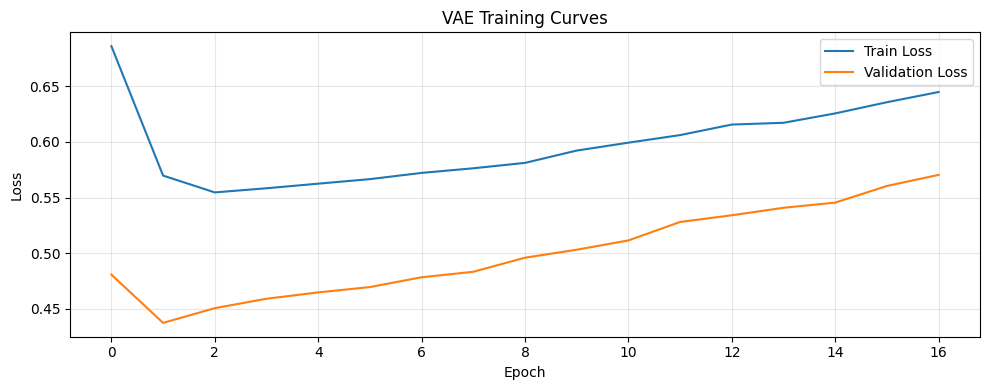

In [ ]:
# =============================================================================
# SECTION 6: TRAINING
# =============================================================================
print("\n" + "=" * 60)
print("SECTION 6: TRAINING")
print("=" * 60)

# Split data
X_train, X_temp = train_test_split(X_scaled, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

print(f"Train set: {len(X_train):,} plays")
print(f"Validation set: {len(X_val):,} plays")
print(f"Test set: {len(X_test):,} plays")

# Create data loaders
BATCH_SIZE = 64
train_dataset = PlayDataset(X_train)
val_dataset = PlayDataset(X_val)
test_dataset = PlayDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training settings
EPOCHS = 100
LEARNING_RATE = 1e-3
BETA_START = 0.0  # Start with pure autoencoder
BETA_END = 1.0    # End with full VAE
BETA_ANNEAL_EPOCHS = 20  # Anneal beta over first N epochs

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training loop
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 15

print(f"\nStarting training for {EPOCHS} epochs...")
print("-" * 50)

for epoch in range(EPOCHS):
    # Calculate beta for this epoch (annealing)
    if epoch < BETA_ANNEAL_EPOCHS:
        beta = BETA_START + (BETA_END - BETA_START) * (epoch / BETA_ANNEAL_EPOCHS)
    else:
        beta = BETA_END

    # Training
    model.train()
    train_loss_epoch = 0
    train_recon_loss = 0
    train_kl_loss = 0

    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon, mu, log_var = model(batch)
        loss, recon_l, kl_l = vae_loss(recon, batch, mu, log_var, beta)

        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        train_recon_loss += recon_l.item()
        train_kl_loss += kl_l.item()

    train_loss_epoch /= len(train_loader)
    train_recon_loss /= len(train_loader)
    train_kl_loss /= len(train_loader)
    train_losses.append(train_loss_epoch)

    # Validation
    model.eval()
    val_loss_epoch = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            recon, mu, log_var = model(batch)
            loss, _, _ = vae_loss(recon, batch, mu, log_var, beta)
            val_loss_epoch += loss.item()

    val_loss_epoch /= len(val_loader)
    val_losses.append(val_loss_epoch)

    # Learning rate scheduling
    scheduler.step(val_loss_epoch)

    # Early stopping check
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_vae_model.pt')
    else:
        patience_counter += 1

    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | β={beta:.2f} | "
              f"Train: {train_loss_epoch:.4f} (R:{train_recon_loss:.4f}, KL:{train_kl_loss:.4f}) | "
              f"Val: {val_loss_epoch:.4f}")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load('best_vae_model.pt'))
print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

In [ ]:
# =============================================================================
# SECTION 7: EXTRACT LATENT REPRESENTATIONS (BASIS FUNCTIONS)
# =============================================================================
print("\n" + "=" * 60)
print("SECTION 7: LATENT REPRESENTATIONS")
print("=" * 60)

# Get latent representations for all plays
model.eval()
all_latent = []

with torch.no_grad():
    for i in range(0, len(X_scaled), BATCH_SIZE):
        batch = torch.FloatTensor(X_scaled[i:i+BATCH_SIZE]).to(device)
        latent = model.get_latent(batch)
        all_latent.append(latent.cpu().numpy())

latent_representations = np.vstack(all_latent)
print(f"Latent representations shape: {latent_representations.shape}")
print(f"Each play is now represented by {LATENT_DIM} basis function coefficients")


SECTION 7: LATENT REPRESENTATIONS
Latent representations shape: (16475, 32)
Each play is now represented by 32 basis function coefficients


In [ ]:
# =============================================================================
# SECTION 8: SIMILARITY DETECTION
# =============================================================================
print("\n" + "=" * 60)
print("SECTION 8: SIMILARITY DETECTION")
print("=" * 60)

def find_similar_plays(query_idx: int, latent_reps: np.ndarray,
                       plays: List[Play], top_k: int = 5) -> List[Tuple[int, float, Play]]:
    """
    Find most similar plays to a query play.

    Args:
        query_idx: Index of query play
        latent_reps: Latent representations matrix
        plays: List of Play objects
        top_k: Number of similar plays to return

    Returns:
        List of (index, similarity_score, Play) tuples
    """
    query_latent = latent_reps[query_idx:query_idx+1]

    # Compute cosine similarity
    similarities = cosine_similarity(query_latent, latent_reps)[0]

    # Get top-k (excluding query itself)
    top_indices = np.argsort(similarities)[::-1][1:top_k+1]

    results = []
    for idx in top_indices:
        results.append((idx, similarities[idx], plays[idx]))

    return results

def describe_play(play: Play) -> str:
    """Generate human-readable description of a play."""
    events = play.events

    # Get event types in sequence
    event_types = []
    for evt in events[:5]:  # First 5 events
        poss_events = evt.get('possessionEvents', {})
        evt_type = poss_events.get('possessionEventType', '?')
        event_types.append(evt_type)

    if len(events) > 5:
        event_types.append(f"...+{len(events)-5}")

    return (f"Game {play.game_id} | {play.team_name} | "
            f"Period {play.period} | {play.set_piece_type} | "
            f"{len(events)} events | {play.duration:.1f}s | "
            f"[{' → '.join(event_types)}]")

# Demo: Find similar plays
print("\n--- SIMILAR PLAYS DEMO ---\n")

# Select a few random plays to query
np.random.seed(42)
query_indices = np.random.choice(len(all_plays), size=3, replace=False)

for query_idx in query_indices:
    query_play = all_plays[query_idx]
    print(f"QUERY PLAY #{query_idx}:")
    print(f"  {describe_play(query_play)}")
    print("\nMost similar plays:")

    similar = find_similar_plays(query_idx, latent_representations, all_plays, top_k=3)
    for i, (idx, sim, play) in enumerate(similar, 1):
        print(f"  {i}. [Similarity: {sim:.3f}] {describe_play(play)}")
    print("-" * 80)


SECTION 8: SIMILARITY DETECTION

--- SIMILAR PLAYS DEMO ---

QUERY PLAY #12810:
  Game 3845 | Netherlands | Period 1 | T | 30 events | 49.1s | [PA → IT → PA → IT → PA → ...+25]

Most similar plays:
  1. [Similarity: 0.940] Game 10511 | Netherlands | Period 1 | O | 28 events | 43.2s | [PA → PA → IT → PA → IT → ...+23]
  2. [Similarity: 0.932] Game 3836 | Japan | Period 1 | O | 48 events | 82.6s | [TC → PA → PA → IT → PA → ...+43]
  3. [Similarity: 0.920] Game 3815 | United States | Period 1 | O | 47 events | 66.9s | [IT → PA → IT → PA → IT → ...+42]
--------------------------------------------------------------------------------
QUERY PLAY #4280:
  Game 10517 | Argentina | Period 4 | K | 7 events | 8.9s | [PA → IT → PA → IT → CH → ...+2]

Most similar plays:
  1. [Similarity: 0.968] Game 3834 | Denmark | Period 1 | K | 5 events | 5.0s | [PA → IT → PA → IT → CH]
  2. [Similarity: 0.952] Game 3859 | Brazil | Period 2 | O | 11 events | 18.5s | [IT → PA → IT → PA → IT → ...+6]
  3. [Simila

In [ ]:
# =============================================================================
# SECTION 9: CLUSTERING AND BASIS ANALYSIS
# =============================================================================
print("\n" + "=" * 60)
print("SECTION 9: CLUSTERING AND BASIS ANALYSIS")
print("=" * 60)

# Cluster plays
N_CLUSTERS = 8
print(f"Clustering plays into {N_CLUSTERS} groups...")

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(latent_representations)

# Cluster statistics
for c in range(N_CLUSTERS):
    cluster_plays = [all_plays[i] for i in range(len(all_plays)) if cluster_labels[i] == c]

    # Get most common characteristics
    teams = [p.team_name for p in cluster_plays]
    set_pieces = [p.set_piece_type for p in cluster_plays]
    durations = [p.duration for p in cluster_plays]
    num_events = [p.num_events for p in cluster_plays]

    from collections import Counter
    top_team = Counter(teams).most_common(1)[0] if teams else ('Unknown', 0)
    top_setpiece = Counter(set_pieces).most_common(1)[0] if set_pieces else ('O', 0)

    print(f"\nCluster {c} ({len(cluster_plays)} plays):")
    print(f"  Top team: {top_team[0]} ({top_team[1]} plays)")
    print(f"  Top set piece: {top_setpiece[0]} ({top_setpiece[1]} plays)")
    print(f"  Avg duration: {np.mean(durations):.1f}s")
    print(f"  Avg events: {np.mean(num_events):.1f}")


SECTION 9: CLUSTERING AND BASIS ANALYSIS
Clustering plays into 8 groups...

Cluster 0 (481 plays):
  Top team: Argentina (34 plays)
  Top set piece: O (378 plays)
  Avg duration: 18.2s
  Avg events: 11.3

Cluster 1 (2551 plays):
  Top team: Croatia (182 plays)
  Top set piece: O (2191 plays)
  Avg duration: 5.2s
  Avg events: 4.0

Cluster 2 (3023 plays):
  Top team: France (175 plays)
  Top set piece: O (1701 plays)
  Avg duration: 15.7s
  Avg events: 9.8

Cluster 3 (1671 plays):
  Top team: Argentina (108 plays)
  Top set piece: O (1259 plays)
  Avg duration: 6.5s
  Avg events: 5.1

Cluster 4 (1101 plays):
  Top team: France (77 plays)
  Top set piece: O (727 plays)
  Avg duration: 13.0s
  Avg events: 8.3

Cluster 5 (2442 plays):
  Top team: Morocco (167 plays)
  Top set piece: O (1830 plays)
  Avg duration: 5.5s
  Avg events: 4.6

Cluster 6 (2561 plays):
  Top team: Argentina (171 plays)
  Top set piece: O (2088 plays)
  Avg duration: 5.5s
  Avg events: 4.3

Cluster 7 (2645 plays):



SECTION 10: VISUALIZATION


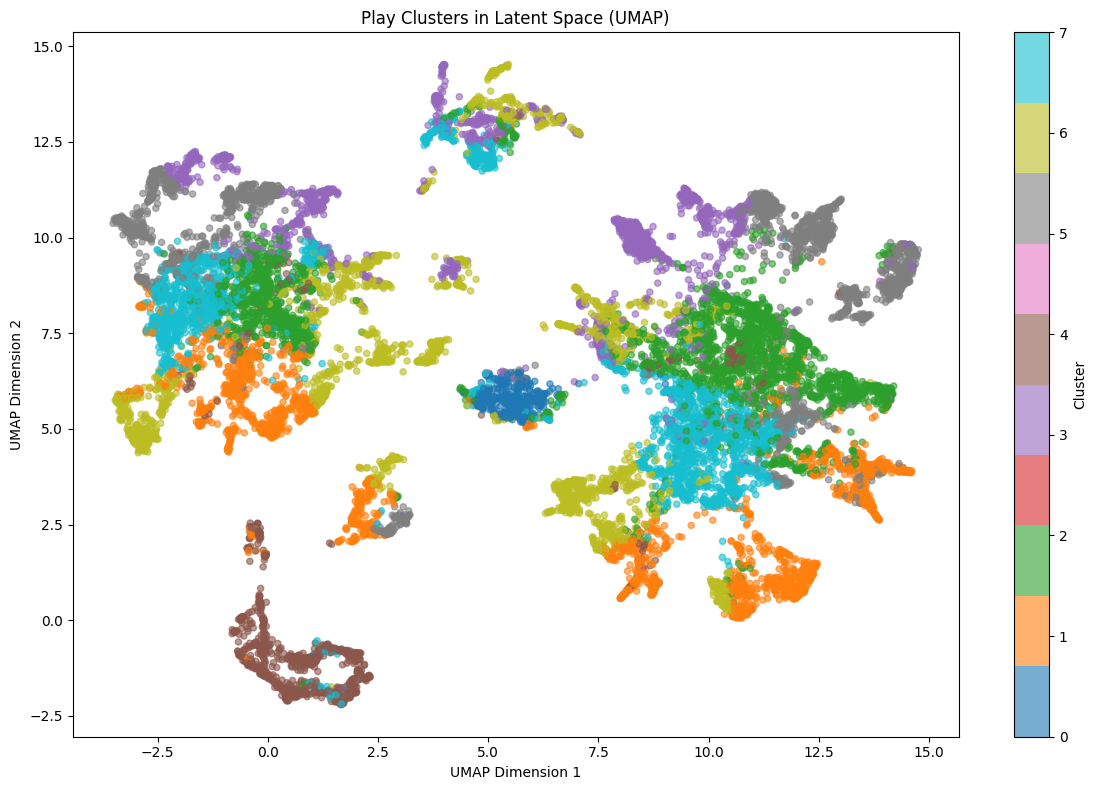

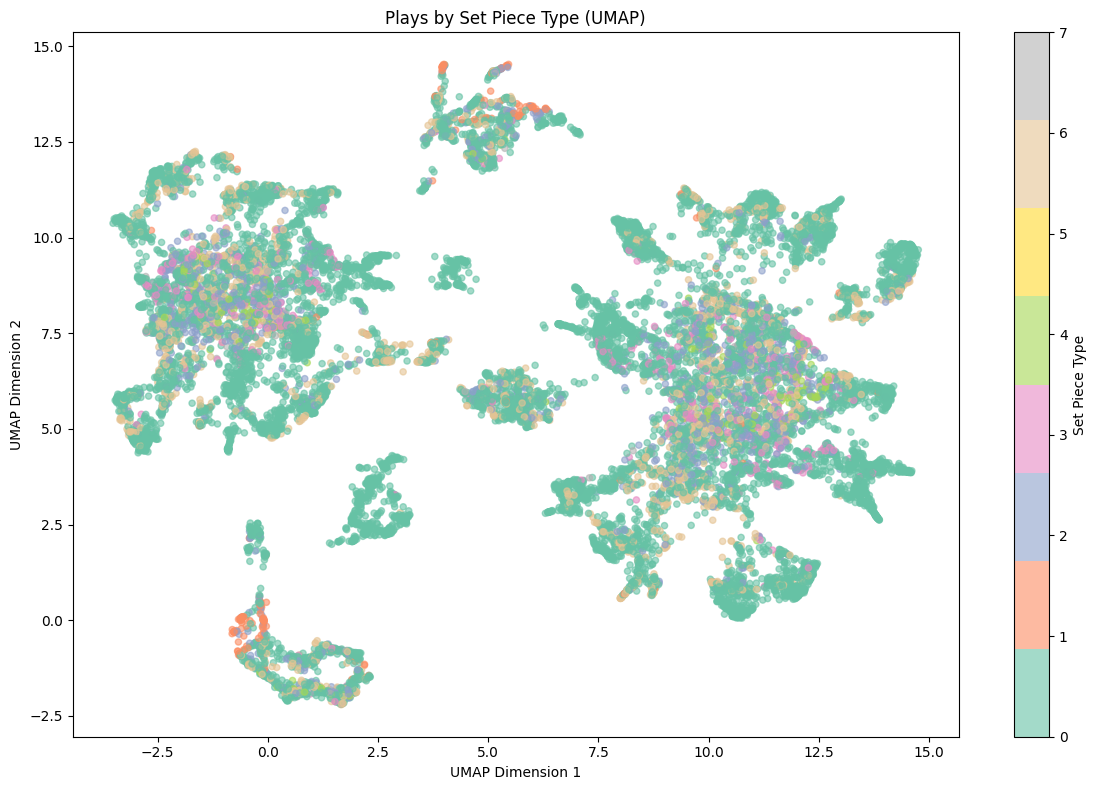


--- BASIS FUNCTION ANALYSIS ---
Correlations between latent dimensions and original features:

Latent Dimension 0 (Basis Function 0):
  Positively correlated with:
    - traj_y_17: 0.670
    - traj_y_16: 0.669
    - traj_y_15: 0.665
  Negatively correlated with:
    - pct_time_on_left: -0.582
    - passes_count: -0.351
    - duration: -0.340

Latent Dimension 1 (Basis Function 1):
  Positively correlated with:
    - y_progression: 0.456
    - event_SH: 0.331
    - ball_zone_def_left: 0.322
  Negatively correlated with:
    - traj_x_18: -0.537
    - traj_x_19: -0.536
    - traj_x_17: -0.532

Latent Dimension 2 (Basis Function 2):
  Positively correlated with:
    - traj_y_18: 0.450
    - traj_y_19: 0.449
    - traj_y_17: 0.447
  Negatively correlated with:
    - event_RE: -0.337
    - ball_dist_to_goal_end: -0.319
    - had_rebound: -0.295

Latent Dimension 3 (Basis Function 3):
  Positively correlated with:
    - traj_x_19: 0.521
    - traj_x_18: 0.516
    - traj_x_20: 0.516
  Negativ

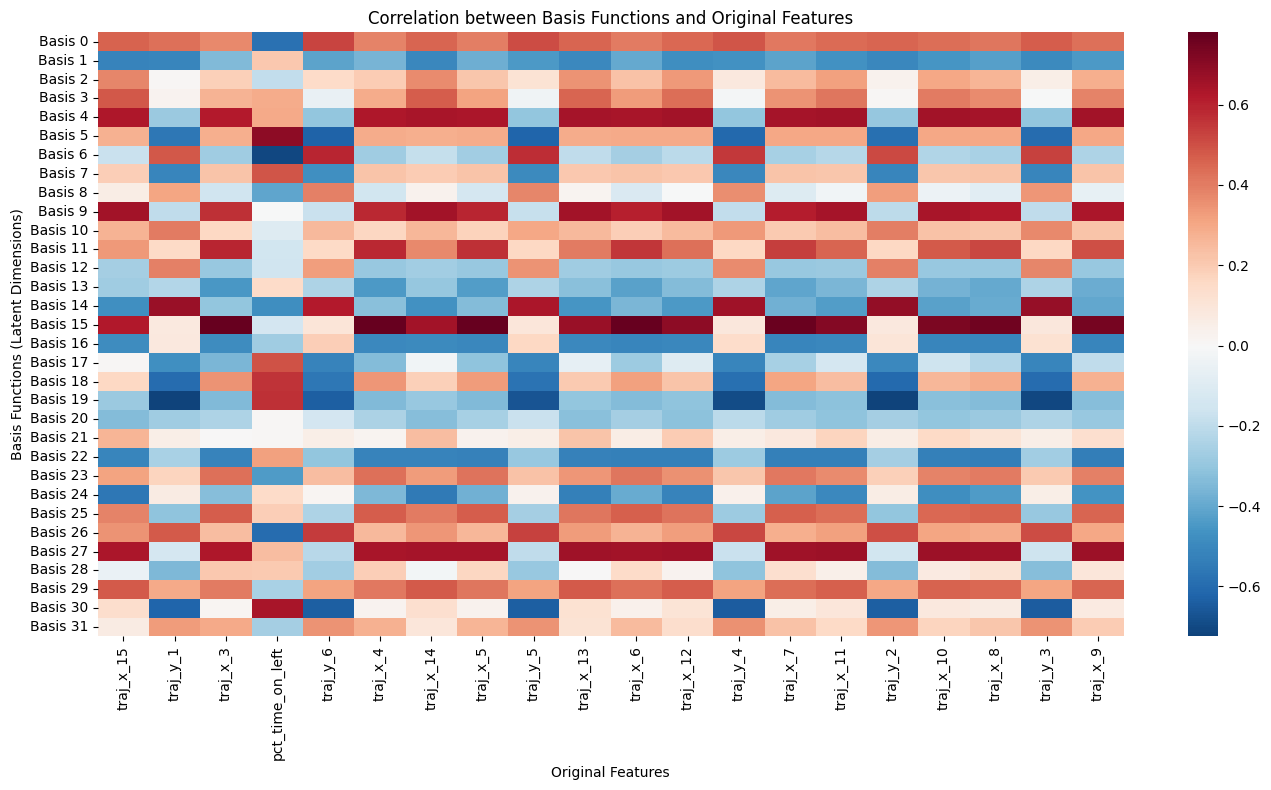

In [ ]:
# =============================================================================
# SECTION 10: VISUALIZATION
# =============================================================================
print("\n" + "=" * 60)
print("SECTION 10: VISUALIZATION")
print("=" * 60)

# Try UMAP first, fall back to t-SNE
try:
    import umap
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding_2d = reducer.fit_transform(latent_representations)
    method = "UMAP"
except ImportError:
    from sklearn.manifold import TSNE
    print("UMAP not available, using t-SNE (slower)...")
    reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    embedding_2d = reducer.fit_transform(latent_representations)
    method = "t-SNE"

# Plot 1: Cluster visualization
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                      c=cluster_labels, cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'{method} Dimension 1')
plt.ylabel(f'{method} Dimension 2')
plt.title(f'Play Clusters in Latent Space ({method})')
plt.tight_layout()
plt.savefig('play_clusters.png', dpi=150)
plt.show()

# Plot 2: Set piece types
set_piece_colors = {'O': 0, 'C': 1, 'F': 2, 'G': 3, 'K': 4, 'P': 5, 'T': 6, 'D': 7}
set_piece_nums = [set_piece_colors.get(p.set_piece_type, 0) for p in all_plays]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                      c=set_piece_nums, cmap='Set2', alpha=0.6, s=20)
plt.colorbar(scatter, label='Set Piece Type')
plt.xlabel(f'{method} Dimension 1')
plt.ylabel(f'{method} Dimension 2')
plt.title(f'Plays by Set Piece Type ({method})')
plt.tight_layout()
plt.savefig('plays_by_setpiece.png', dpi=150)
plt.show()

# Plot 3: Latent dimension analysis
print("\n--- BASIS FUNCTION ANALYSIS ---")
print("Correlations between latent dimensions and original features:")

# Compute correlations
correlations = np.corrcoef(latent_representations.T, X_scaled.T)[:LATENT_DIM, LATENT_DIM:]

# For each latent dimension, find top correlated features
for dim in range(min(5, LATENT_DIM)):  # Show first 5 dimensions
    corrs = correlations[dim]
    top_pos_idx = np.argsort(corrs)[-3:][::-1]
    top_neg_idx = np.argsort(corrs)[:3]

    print(f"\nLatent Dimension {dim} (Basis Function {dim}):")
    print("  Positively correlated with:")
    for idx in top_pos_idx:
        if idx < len(extractor.feature_names):
            print(f"    - {extractor.feature_names[idx]}: {corrs[idx]:.3f}")
    print("  Negatively correlated with:")
    for idx in top_neg_idx:
        if idx < len(extractor.feature_names):
            print(f"    - {extractor.feature_names[idx]}: {corrs[idx]:.3f}")

# Heatmap of correlations
plt.figure(figsize=(14, 8))
# Select top features by variance in correlation
feat_var = np.var(correlations, axis=0)
top_feat_idx = np.argsort(feat_var)[-20:]  # Top 20 features
top_feat_names = [extractor.feature_names[i] if i < len(extractor.feature_names) else f'feat_{i}'
                  for i in top_feat_idx]

sns.heatmap(correlations[:, top_feat_idx],
            xticklabels=top_feat_names,
            yticklabels=[f'Basis {i}' for i in range(LATENT_DIM)],
            cmap='RdBu_r', center=0, annot=False)
plt.xlabel('Original Features')
plt.ylabel('Basis Functions (Latent Dimensions)')
plt.title('Correlation between Basis Functions and Original Features')
plt.tight_layout()
plt.savefig('basis_correlations.png', dpi=150)
plt.show()

In [ ]:
# =============================================================================
# SECTION 11: SAVE RESULTS
# =============================================================================
print("\n" + "=" * 60)
print("SECTION 11: SAVE RESULTS")
print("=" * 60)

# Save latent representations
np.save('latent_representations.npy', latent_representations)
print("Saved: latent_representations.npy")

# Save cluster labels
np.save('cluster_labels.npy', cluster_labels)
print("Saved: cluster_labels.npy")

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'input_dim': INPUT_DIM,
    'hidden_dims': HIDDEN_DIMS,
    'latent_dim': LATENT_DIM,
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
}, 'vae_model_complete.pt')
print("Saved: vae_model_complete.pt")

# Save play metadata
play_metadata = []
for i, play in enumerate(all_plays):
    play_metadata.append({
        'play_index': i,
        'game_id': play.game_id,
        'play_id': play.play_id,
        'team_id': play.team_id,
        'team_name': play.team_name,
        'period': play.period,
        'set_piece_type': play.set_piece_type,
        'duration': play.duration,
        'num_events': play.num_events,
        'cluster': int(cluster_labels[i])
    })

pd.DataFrame(play_metadata).to_csv('play_metadata.csv', index=False)
print("Saved: play_metadata.csv")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE!")
print("=" * 60)
print(f"""
Summary:
- Analyzed {len(all_plays):,} plays from {len(matches)} matches
- Extracted {INPUT_DIM} features per play
- Learned {LATENT_DIM} basis functions
- Clustered plays into {N_CLUSTERS} groups

Files saved:
- latent_representations.npy: Latent vectors for all plays
- cluster_labels.npy: Cluster assignments
- vae_model_complete.pt: Trained VAE model
- play_metadata.csv: Play information with clusters
- training_curves.png: Training loss plot
- play_clusters.png: Cluster visualization
- plays_by_setpiece.png: Set piece visualization
- basis_correlations.png: Basis function analysis

To find similar plays, use:
  similar = find_similar_plays(play_index, latent_representations, all_plays, top_k=5)
""")


SECTION 11: SAVE RESULTS
Saved: latent_representations.npy
Saved: cluster_labels.npy
Saved: vae_model_complete.pt
Saved: play_metadata.csv

ANALYSIS COMPLETE!

Summary:
- Analyzed 16,475 plays from 64 matches
- Extracted 119 features per play
- Learned 32 basis functions
- Clustered plays into 8 groups

Files saved:
- latent_representations.npy: Latent vectors for all plays
- cluster_labels.npy: Cluster assignments
- vae_model_complete.pt: Trained VAE model
- play_metadata.csv: Play information with clusters
- training_curves.png: Training loss plot
- play_clusters.png: Cluster visualization
- plays_by_setpiece.png: Set piece visualization
- basis_correlations.png: Basis function analysis

To find similar plays, use:
  similar = find_similar_plays(play_index, latent_representations, all_plays, top_k=5)



In [ ]:
# ============================================================
# 🔍 FEATURE QUALITY CHECK
# ============================================================

def check_feature_quality():
    """Check data quality of all extracted features."""
    print("\n" + "="*70)
    print("🔍 FEATURE QUALITY CHECK")
    print("="*70)

    # Feature name to index mapping
    feat_dict = {name: i for i, name in enumerate(extractor.feature_names)}

    print(f"\nTotal plays: {len(X):,}")
    print(f"Total features: {len(extractor.feature_names)}")

    # Check for issues
    issues = []

    print(f"\n{'Feature':<35} {'Mean':>10} {'Std':>10} {'Zero%':>10} {'NaN%':>10}")
    print("-"*75)

    for name in extractor.feature_names:
        idx = feat_dict[name]
        col = X[:, idx]

        mean_val = np.mean(col)
        std_val = np.std(col)
        zero_pct = np.sum(col == 0) / len(col) * 100
        nan_pct = np.sum(np.isnan(col)) / len(col) * 100

        # Flag potential issues
        flag = ""
        if nan_pct > 0:
            flag = "⚠️ NaN"
            issues.append((name, f"Has {nan_pct:.1f}% NaN values"))
        elif zero_pct > 99:
            flag = "⚠️ All Zero"
            issues.append((name, f"{zero_pct:.1f}% zeros"))
        elif std_val == 0:
            flag = "⚠️ Constant"
            issues.append((name, "No variance"))

        print(f"{name:<35} {mean_val:>10.3f} {std_val:>10.3f} {zero_pct:>9.1f}% {nan_pct:>9.1f}% {flag}")

    # Summary
    print("\n" + "="*70)
    print("📋 SUMMARY")
    print("="*70)

    # Check new features specifically
    print("\n🆕 New Feature Validation:")

    # has_speed_data
    speed_idx = feat_dict['has_speed_data']
    has_speed = np.sum(X[:, speed_idx] == 1.0)
    no_speed = np.sum(X[:, speed_idx] == 0.0)
    print(f"   has_speed_data: {has_speed:,} plays WITH speed ({has_speed/len(X)*100:.1f}%), {no_speed:,} WITHOUT ({no_speed/len(X)*100:.1f}%)")

    # tempo
    tempo_idx = feat_dict['tempo']
    print(f"   tempo: mean={np.mean(X[:, tempo_idx]):.2f}, max={np.max(X[:, tempo_idx]):.2f} m/s")

    # foul_count
    foul_idx = feat_dict['foul_count']
    total_fouls = np.sum(X[:, foul_idx])
    plays_with_fouls = np.sum(X[:, foul_idx] > 0)
    print(f"   foul_count: {int(total_fouls)} total fouls in {int(plays_with_fouls)} plays ({plays_with_fouls/len(X)*100:.1f}%)")

    # Pressure distribution
    print("\n🎯 Pressure Distribution:")
    for p in ['N', 'A', 'P', 'L']:
        p_idx = feat_dict[f'pressure_{p}']
        pct = np.mean(X[:, p_idx]) * 100
        print(f"   pressure_{p}: {pct:.1f}%")

    # Issues summary
    if issues:
        print(f"\n⚠️ ISSUES FOUND ({len(issues)}):")
        for name, issue in issues[:10]:
            print(f"   - {name}: {issue}")
    else:
        print("\n✅ No major issues found!")

    return issues

# Run the check
issues = check_feature_quality()


🔍 FEATURE QUALITY CHECK

Total plays: 16,475
Total features: 119

Feature                                   Mean        Std      Zero%       NaN%
---------------------------------------------------------------------------
ball_x_start                             0.408     26.014      11.2%       0.0% 
ball_y_start                            -0.014     19.007      11.2%       0.0% 
ball_x_end                               0.900     28.415       4.1%       0.0% 
ball_y_end                              -0.701     20.032       4.1%       0.0% 
ball_dist_to_goal_start                 64.103     22.278       0.0%       0.0% 
ball_dist_to_goal_end                   51.633     25.485       0.0%       0.0% 
ball_zone_def_left                       0.082      0.274      91.8%       0.0% 
ball_zone_def_center                     0.094      0.292      90.6%       0.0% 
ball_zone_def_right                      0.077      0.266      92.3%       0.0% 
ball_zone_mid_left                       0.134  

In [ ]:
# ============================================================
# 📊 ANALYSIS FUNCTIONS (Updated for new feature names)
# ============================================================

feat_dict = {name: i for i, name in enumerate(extractor.feature_names)}

# ------------------------------------------------------------
# 🆚 COMPARE TWO TEAMS (across all their matches)
# ------------------------------------------------------------
def compare_teams(team1, team2):
    """Compare two teams across all their plays."""
    idx1 = [i for i, p in enumerate(all_plays) if team1 in p.team_name]
    idx2 = [i for i, p in enumerate(all_plays) if team2 in p.team_name]

    if not idx1 or not idx2:
        print(f"Team not found. Available: {sorted(set(p.team_name for p in all_plays))}")
        return

    print(f"\n{'='*70}")
    print(f"🆚 {team1} vs {team2}")
    print(f"{'='*70}")
    print(f"   Total plays: {len(idx1)} vs {len(idx2)}\n")

    # Updated feature names to match current code
    metrics = [
        ('distance_covered_ball', '⚔️ Ball Movement', True),
        ('ball_dist_to_goal_start', '📍 Avg Dist to Goal (Start)', False),
        ('ball_dist_to_goal_end', '🎯 Avg Dist to Goal (End)', False),
        ('event_PA', '🔄 Pass Frequency', True),
        ('event_SH', '🥅 Shot Frequency', True),
        ('event_CH', '🛡️ Challenge Frequency', True),
        ('event_CR', '↗️ Cross Frequency', True),
        ('successful_passes_ratio', '✅ Pass Accuracy', True),
        ('duration', '⏱️ Possession Length (s)', True),
        ('num_events', '📊 Events/Possession', True),
        ('avg_speed_home', '⚡ Team Speed', True),
        ('home_compactness', '🎯 Team Compactness', False),
        ('tempo', '🏃 Tempo (m/s)', True),
        ('foul_count', '⚠️ Fouls Received', False),
        ('x_progression', '➡️ Forward Progress', True),
    ]

    print(f"{'Metric':<30} {team1[:12]:<14} {team2[:12]:<14} {'Winner':<12}")
    print("-"*70)

    for feat, label, higher_better in metrics:
        if feat in feat_dict:
            v1 = np.mean(X[idx1, feat_dict[feat]])
            v2 = np.mean(X[idx2, feat_dict[feat]])
            winner = team1 if (v1 > v2) == higher_better else team2
            print(f"{label:<30} {v1:<14.3f} {v2:<14.3f} {winner[:12]:<12}")

# ------------------------------------------------------------
# 🏟️ ANALYZE A SPECIFIC MATCH
# ------------------------------------------------------------
def analyze_match(match_id):
    """Detailed analysis of a specific match."""
    match_plays = [(i, p) for i, p in enumerate(all_plays) if p.game_id == match_id]

    if not match_plays:
        print(f"Match {match_id} not found.")
        print(f"Available matches: {sorted(set(p.game_id for p in all_plays))[:10]}...")
        return

    # Group by team
    by_team = defaultdict(list)
    for i, p in match_plays:
        by_team[p.team_name].append((i, p))

    teams = list(by_team.keys())
    print(f"\n{'='*70}")
    print(f"🏟️ MATCH {match_id}: {' vs '.join(teams)}")
    print(f"{'='*70}")

    for team, plays in by_team.items():
        print(f"\n{'─'*35}")
        print(f"🏆 {team}: {len(plays)} possessions")
        print(f"{'─'*35}")

        indices = [i for i, p in plays]

        # Set pieces
        sp_counts = Counter([p.set_piece_type for i, p in plays])
        sp_names = {'O': 'Open', 'K': 'Kickoff', 'F': 'FreeKick', 'C': 'Corner',
                    'T': 'Throw', 'G': 'GoalKick', 'D': 'DropBall'}
        sp_str = ', '.join([f"{sp_names.get(k,k)}:{v}" for k,v in sp_counts.most_common(4)])
        print(f"   Set Pieces: {sp_str}")

        # Key stats (updated feature names)
        print(f"   Avg Duration: {np.mean([p.duration for i,p in plays]):.1f}s")
        print(f"   Avg Events: {np.mean([p.num_events for i,p in plays]):.1f}")
        print(f"   Pass Success: {np.mean(X[indices, feat_dict['successful_passes_ratio']]):.1%}")
        print(f"   Avg Tempo: {np.mean(X[indices, feat_dict['tempo']]):.2f} m/s")
        print(f"   Avg X Progress: {np.mean(X[indices, feat_dict['x_progression']]):.1f}m")

        # Shots
        shots = sum(X[indices, feat_dict['event_SH']] * np.array([p.num_events for i,p in plays]))
        print(f"   Shots: {shots:.0f}")

        # Fouls
        fouls = sum(X[indices, feat_dict['foul_count']])
        print(f"   Fouls: {int(fouls)}")

        # Pressure received (using correct location now)
        press_counts = Counter()
        for i, p in plays:
            pr = p.events[0].get('initialTouch', {}).get('initialPressureType', 'N') or 'N'
            press_counts[pr] += 1
        press_pct = press_counts.get('P', 0) / len(plays) * 100
        print(f"   Under Pressure: {press_pct:.1f}%")

        # Top 3 plays
        print(f"\n   Top 3 Longest Plays:")
        sorted_plays = sorted(plays, key=lambda x: x[1].num_events, reverse=True)[:3]
        for idx, play in sorted_plays:
            evts = [e.get('possessionEvents', {}).get('possessionEventType') or '?' for e in play.events[:4]]
            print(f"     [{idx}] {play.num_events}evts | {play.duration:.1f}s | {' → '.join(evts)}")

# ------------------------------------------------------------
# 🏆 RANK ALL TEAMS BY PLAY STYLE
# ------------------------------------------------------------
def rank_teams():
    """Rank all teams by different play styles (using raw features)."""
    all_teams = list(set(p.team_name for p in all_plays))

    # Updated feature names - use raw values, not scaled
    styles = {
        '⚔️ ATTACKING': ['shots_count', 'event_CR', 'x_progression'],
        '🔄 POSSESSION': ['passes_count', 'duration', 'successful_passes_ratio', 'num_events'],
        '⚡ COUNTER-ATTACK': ['tempo', 'distance_covered_ball', 'ball_carrier_speed_max'],
        '🛡️ DEFENSIVE': ['event_CH', 'event_CL', 'event_TC'],
        '💪 PHYSICAL': ['foul_count', 'challenges_count'],
    }

    def score_team(team, features):
        indices = [i for i, p in enumerate(all_plays) if team in p.team_name]
        if not indices:
            return 0
        # Use RAW X, not X_scaled, and use actual mean (not abs)
        scores = [np.mean(X[indices, feat_dict[f]]) for f in features if f in feat_dict]
        return np.mean(scores) if scores else 0

    print("\n" + "="*60)
    print("🏆 TEAM RANKINGS BY PLAY STYLE")
    print("="*60)

    for style_name, features in styles.items():
        print(f"\n{style_name}:")
        print("-"*40)
        scores = [(team, score_team(team, features)) for team in all_teams]
        scores.sort(key=lambda x: x[1], reverse=True)
        for i, (team, score) in enumerate(scores[:5], 1):
            plays_count = len([p for p in all_plays if team in p.team_name])
            print(f"  {i}. {team:<20} {score:.3f}  ({plays_count} plays)")

In [ ]:
# Compare any two teams
compare_teams("Argentina", "France")
compare_teams("Germany", "Spain")
compare_teams("Saudi Arabia", "Argentina")

# Analyze a specific match
analyze_match(3816)  # Argentina vs Saudi Arabia
analyze_match(3851)  # Find match IDs from team plays

# Rank all teams
rank_teams()


🆚 Argentina vs France
   Total plays: 973 vs 907

Metric                         Argentina      France         Winner      
----------------------------------------------------------------------
⚔️ Ball Movement               27.483         27.856         France      
📍 Avg Dist to Goal (Start)     62.472         64.117         Argentina   
🎯 Avg Dist to Goal (End)       49.788         49.610         France      
🔄 Pass Frequency               0.459          0.438          Argentina   
🥅 Shot Frequency               0.020          0.020          France      
🛡️ Challenge Frequency         0.143          0.158          France      
↗️ Cross Frequency             0.012          0.023          France      
✅ Pass Accuracy                0.677          0.644          Argentina   
⏱️ Possession Length (s)       13.608         12.631         Argentina   
📊 Events/Possession            9.145          8.343          Argentina   
⚡ Team Speed                   1.596          1.012          Arg

In [ ]:
# Find match IDs for a team
team_matches = set(p.game_id for p in all_plays if 'Brazil' in p.team_name)
print(f"Brazil played in matches: {team_matches}")

Brazil played in matches: {3842, 10507, 10510, 3859, 3827}


In [ ]:
# ============================================================
# ⚽ FIND SIMILAR GOALS (V4 - with event count control)
# ============================================================

def find_similar_goals(team_or_match, top_k=5, show_events=5):
    """
    Find similar goal-scoring plays for a team or match.

    Args:
        team_or_match: Team name (str) or match_id (int)
        top_k: Number of similar goals to show
        show_events: Number of events to show in sequence.
                     Use -1 or 'all' to show all events.
    """

    # Build match lookup
    match_teams = {}
    for p in all_plays:
        if p.game_id not in match_teams:
            match_teams[p.game_id] = set()
        match_teams[p.game_id].add(p.team_name)

    # Collect all goals with metadata
    goals_by_match_team = {}

    for i, p in enumerate(all_plays):
        if p.set_piece_type == 'P':
            continue
        for evt in p.events:
            poss = evt.get('possessionEvents', {})
            if poss.get('possessionEventType') == 'SH' and poss.get('shotOutcomeType') == 'G':
                game_events = evt.get('gameEvents', {})
                formatted_clock = game_events.get('startFormattedGameClock', '?:?')
                minute = formatted_clock.split(':')[0] if ':' in formatted_clock else '?'

                key = (p.game_id, p.team_name)
                if key not in goals_by_match_team:
                    goals_by_match_team[key] = []
                goals_by_match_team[key].append((i, p, minute))
                break

    # Assign goal numbers
    all_goals_data = []
    for (match_id, team), goals_list in goals_by_match_team.items():
        goals_list.sort(key=lambda x: x[0])
        teams_in_match = match_teams.get(match_id, set())
        opponent = [t for t in teams_in_match if t != team]
        opponent = opponent[0] if opponent else "?"

        for goal_num, (idx, play, minute) in enumerate(goals_list, 1):
            all_goals_data.append({
                'idx': idx, 'play': play, 'team': team, 'opponent': opponent,
                'minute': minute, 'goal_num': goal_num, 'total_goals': len(goals_list)
            })

    # Helper function to format event sequence
    def format_events(play, max_events):
        evts = [e.get('possessionEvents', {}).get('possessionEventType') or '?'
                for e in play.events]

        if max_events == -1 or max_events == 'all' or max_events >= len(evts):
            # Show all events
            return ' → '.join(evts)
        else:
            # Show limited events
            shown = evts[:max_events]
            remaining = len(evts) - max_events
            result = ' → '.join(shown)
            if remaining > 0:
                result += f" ...+{remaining}"
            return result

    # Filter for requested team/match
    if isinstance(team_or_match, int):
        query_goals = [g for g in all_goals_data if g['play'].game_id == team_or_match]
        title = f"Match {team_or_match}"
    else:
        query_goals = [g for g in all_goals_data
                       if team_or_match.lower() in g['team'].lower()]
        title = team_or_match

    if not query_goals:
        print(f"\n⚽ No goals found for {title}")
        return None

    print(f"\n{'='*70}")
    print(f"⚽ GOALS BY: {title}")
    print(f"{'='*70}")
    print(f"Found {len(query_goals)} goals | Total in tournament: {len(all_goals_data)}\n")

    # Set piece names
    sp_names = {'O': 'Open Play', 'K': 'Kickoff', 'F': 'Free Kick',
                'C': 'Corner', 'T': 'Throw-in', 'G': 'Goal Kick', 'D': 'Drop Ball'}

    for g in query_goals:
        play = g['play']
        print(f"{'─'*70}")

        evt_str = format_events(play, show_events)
        sp_name = sp_names.get(play.set_piece_type, play.set_piece_type)

        print(f"\n⚽ {g['team']} Goal #{g['goal_num']}/{g['total_goals']} vs {g['opponent']} ({g['minute']}')")
        print(f"   Match {play.game_id} | Period {play.period} | {play.duration:.1f}s | {sp_name}")
        print(f"   Sequence: {evt_str}")

        # Similarity
        query_latent = latent_representations[g['idx']].reshape(1, -1)
        similarities = []
        for other_g in all_goals_data:
            if other_g['idx'] == g['idx']:
                continue
            other_latent = latent_representations[other_g['idx']].reshape(1, -1)
            sim = cosine_similarity(query_latent, other_latent)[0, 0]
            similarities.append((sim, other_g))

        similarities.sort(reverse=True, key=lambda x: x[0])

        print(f"\n   🔍 Top {top_k} Similar Goals:")
        for rank, (sim, other_g) in enumerate(similarities[:top_k], 1):
            other_play = other_g['play']
            # Handle 'all' string case
            if show_events == 'all' or show_events == -1:
                other_evt_str = format_events(other_play, -1)
            else:
                other_evt_str = format_events(other_play, min(4, show_events))

            print(f"      {rank}. [{sim:.3f}] {other_g['team']} #{other_g['goal_num']} vs {other_g['opponent']} ({other_g['minute']}')")
            print(f"           Match {other_play.game_id} | {other_play.duration:.1f}s | {other_evt_str}")

    print(f"\n{'='*70}")


# ============================================================
# USAGE EXAMPLES
# ============================================================

# Show 5 events (default)
# find_similar_goals("France")

# Show ALL events
# find_similar_goals("France", show_events=-1)
# find_similar_goals("France", show_events='all')

# Show only 3 events
# find_similar_goals("Argentina", show_events=3)

# Show 10 events
# find_similar_goals(3816, top_k=3, show_events=10)

In [ ]:
find_similar_goals("France", show_events='all')


⚽ GOALS BY: France
Found 12 goals | Total in tournament: 150

──────────────────────────────────────────────────────────────────────

⚽ France Goal #1/3 vs Poland (43')
   Match 10504 | Period 1 | 26.0s | Throw-in
   Sequence: PA → IT → PA → IT → PA → IT → PA → IT → PA → PA → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → SH

   🔍 Top 5 Similar Goals:
      1. [0.798] Morocco #2 vs Belgium (91')
           Match 3837 | 11.5s | PA → CH → PA → PA → IT → CH → PA → SH
      2. [0.795] Spain #3 vs Costa Rica (53')
           Match 3822 | 47.4s | IT → PA → PA → IT → PA → PA → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → CH → PA → PA → IT → PA → IT → PA → PA → IT → CH → CH → SH
      3. [0.780] Spain #5 vs Costa Rica (91')
           Match 3822 | 27.5s | IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → PA → SH
      4. [0.721] Poland #1 vs Saudi Arabia (38')
           Match 3833 | 14.2s | PA → PA → IT →

In [ ]:
find_similar_goals("Netherlands", show_events='all')


⚽ GOALS BY: Netherlands
Found 9 goals | Total in tournament: 150

──────────────────────────────────────────────────────────────────────

⚽ Netherlands Goal #1/3 vs United States (09')
   Match 10502 | Period 1 | 59.3s | Open Play
   Sequence: PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → BC → PA → IT → CH → PA → IT → PA → IT → PA → IT → PA → IT → PA → PA → PA → PA → PA → IT → PA → PA → SH

   🔍 Top 5 Similar Goals:
      1. [0.709] Portugal #7 vs Switzerland (91')
           Match 10509 | 52.3s | PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → BC → PA → IT → PA → IT → PA → IT → PA → IT → PA → IT → PA → PA → PA → IT → SH
      2. [0.604] Ghana #3 vs South Korea (67')
           Match 3841 | 21.9s | PA → IT → PA → IT → PA → IT → PA → IT → PA → BC → PA → IT → PA → PA → SH → SH
      3. [0.600] Spain #2 vs Costa Rica (20')
           Match 3822 | 80.8s | TC → CH → PA → PA → IT → PA → IT → PA → IT → PA →

In [ ]:
# ============================================================
# EXPORT MODEL OUTPUTS FOR WEBSITE
# ============================================================

import pickle
import os

# 🔧 CHANGE THIS TO YOUR DESIRED LOCATION:
# OUTPUT_DIR = r'd:\world cup\model_outputs'  # Local
OUTPUT_DIR = '/content/drive/MyDrive/model_outputs'  # Colab

# Create directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Saving to: {OUTPUT_DIR}\n")

# 1. Latent representations (for similarity search)
np.save(f'{OUTPUT_DIR}/latent_representations.npy', latent_representations)
print("✅ Saved: latent_representations.npy")

# 2. All plays (for event data & visualization)
with open(f'{OUTPUT_DIR}/all_plays.pkl', 'wb') as f:
    pickle.dump(all_plays, f)
print("✅ Saved: all_plays.pkl")

# 3. Scaler (for normalizing new features)
with open(f'{OUTPUT_DIR}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Saved: scaler.pkl")

# 4. Model weights (for encoding new plays)
torch.save(model.state_dict(), f'{OUTPUT_DIR}/vae_model.pth')
print("✅ Saved: vae_model.pth")

# 5. Feature extractor (for extracting features from new plays)
with open(f'{OUTPUT_DIR}/feature_extractor.pkl', 'wb') as f:
    pickle.dump(extractor, f)
print("✅ Saved: feature_extractor.pkl")

print(f"\n🎉 All files saved to: {OUTPUT_DIR}")

Saving to: /content/drive/MyDrive/model_outputs

✅ Saved: latent_representations.npy
✅ Saved: all_plays.pkl
✅ Saved: scaler.pkl
✅ Saved: vae_model.pth
✅ Saved: feature_extractor.pkl

🎉 All files saved to: /content/drive/MyDrive/model_outputs


# OLD:
if poss.get('shotOutcomeType') == 'G':
    goal_plays.append(...)

# NEW - Filter out disallowed goals:
if poss.get('shotOutcomeType') == 'G':
    # Skip if nonEvent is True (VAR disallowed)
    if poss.get('nonEvent') == True:
        continue
    goal_plays.append(...)

# Find goal-scoring plays for the query team
goal_plays = []
for idx, play in team_plays:
    events = play.events
    for evt in events:
        poss = evt.get('possessionEvents', {})
        if poss.get('possessionEventType') == 'SH':
            shot_outcome = poss.get('shotOutcomeType', '')
            # Skip disallowed goals (VAR/offside)
            if poss.get('nonEvent') == True:
                continue
            if shot_outcome in ['G', 'O']:
                goal_plays.append((idx, play, shot_outcome))
                break